# Segmenting and Clustering Neighborhoods in Toronto - Part 3

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you. 

Just make sure:

<ol>
    <li>to add enough Markdown cells to explain what you decided to do and to report any observations you make.
    <li>to generate maps to visualize your neighborhoods and how they cluster together.

### Explore and cluster the neighborhoods in Toronto

First, we need to install the dependencies

In [1]:
!pip install geopy
!pip install folium==0.5.0

Importing required libraries

In [2]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize

import json

import requests

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium
from geopy.geocoders import Nominatim

Importing CSV file, created on the previous notebook 'Segmenting and Clustering Neighborhoods in Toronto - Part 2'

In [3]:
toronto_coordinates = pd.read_csv('toronto_coordinates.csv')
toronto_coordinates.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Filtering dataframe by only boroughs that contain the word Toronto

In [4]:
toronto_borough = toronto_coordinates[toronto_coordinates['Borough'].str.contains('Toronto')]
toronto_borough.reset_index(inplace=True, drop=True)
print(toronto_borough.shape)
toronto_borough.head()

(39, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Use geopy library to get the latitude and longitude values of Toronto.

In [5]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Create a map of Toronto with neighborhoods superimposed on top.

In [6]:
# create map of Toronto using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_borough['Latitude'], toronto_borough['Longitude'], 
                                           toronto_borough['Borough'], toronto_borough['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### The output above is not shown on github, so bellow the print screen image of the output is displayed

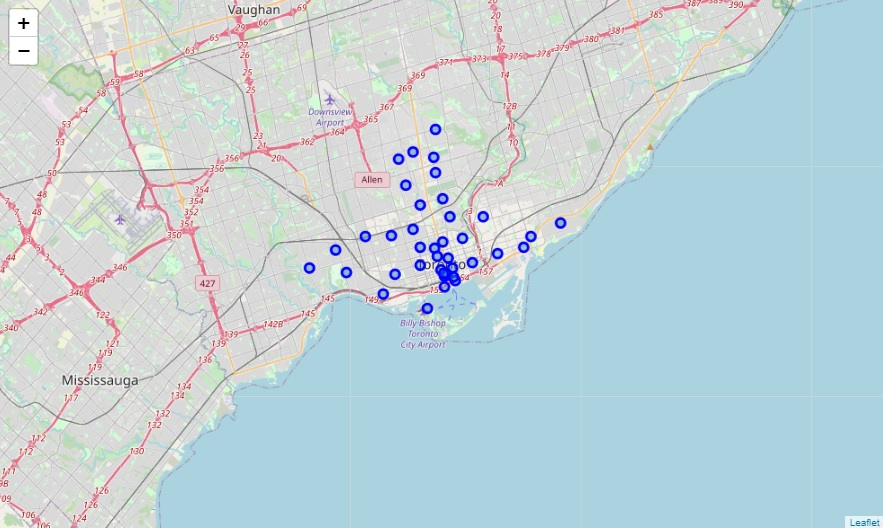

In [7]:
from IPython.display import Image
Image(filename='toronto_borough_map.jpg') 

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

### Define Foursquare Credentials and Version

In [1]:
CLIENT_ID = 'YOUR-CLIENT-ID-HERE' # your Foursquare ID
CLIENT_SECRET = 'YOUR-CLIENT-SECRET-HERE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YOUR-CLIENT-ID-HERE
CLIENT_SECRET:YOUR-CLIENT-SECRET-HERE


### Now, let's get the top 100 venues that are in each Neighbourhood within a radius of 500 meters.

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Running the above function on each neighbourhood and create a new dataframe called toronto_venues.

In [10]:
toronto_venues = getNearbyVenues(names=toronto_borough['Neighbourhood'],
                                   latitudes=toronto_borough['Latitude'],
                                   longitudes=toronto_borough['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [11]:
# checking the size of the resulting dataframe
print(toronto_venues.shape)
toronto_venues.head()

(1618, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [12]:
# counting how many venues were returned for each neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",15,15,15,15,15,15
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,65,65,65,65,65,65
Christie,16,16,16,16,16,16
Church and Wellesley,80,80,80,80,80,80
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34


### Let's find out how many unique categories can be curated from all the returned venues

In [13]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 232 uniques categories.


## Analyze Each Neighborhood

In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [15]:
# New dataframe size
toronto_onehot.shape

(1618, 232)

### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [16]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017241,0.000000,0.0,0.0,0.0,0.0,0.0,0.017241,0.034483,0.000000,0.000000,0.0,0.017241,0.017241,0.0,0.034483,0.0,0.0,0.017241,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.017241,0.017241,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.000000,0.017241,0.051724,0.103448,0.0,0.0,0.0,0.0,0.0,0.0,0.017241,0.000000,0.017241,0.000000,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.000000,0.0,0.017241,0.000000,0.0,0.0,0.0,0.000000,0.017241,0.0,0.0,0.0,0.0,0.000000,0.034483,0.000000,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.0,0.017241,0.017241,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000

In [17]:
# New dataframe size
toronto_grouped.shape

(39, 232)

### Let's print each neighborhood along with the top 5 most common venues

In [18]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.10
1        Cocktail Bar  0.05
2      Farmers Market  0.03
3  Seafood Restaurant  0.03
4         Cheese Shop  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.12
1          Bakery  0.08
2  Breakfast Spot  0.08
3     Coffee Shop  0.08
4     Yoga Studio  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
           venue  freq
0    Pizza Place  0.07
1  Garden Center  0.07
2           Park  0.07
3     Restaurant  0.07
4        Butcher  0.07


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.18
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3             Plane  0.06
4           Airport  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.18
1      Sandwich Place 

### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Bakery,Cheese Shop,Seafood Restaurant,Restaurant,Grocery Store,Japanese Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Breakfast Spot,Coffee Shop,Grocery Store,Gym,Pet Store,Performing Arts Venue,Nightclub,Italian Restaurant
2,"Business reply mail Processing Centre, South C...",Pizza Place,Garden Center,Restaurant,Burrito Place,Fast Food Restaurant,Farmers Market,Spa,Garden,Butcher,Brewery
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boutique,Rental Car Location,Sculpture Garden,Plane,Boat or Ferry,Bar
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint,Salad Place,Bubble Tea Shop,Thai Restaurant,Ramen Restaurant,Portuguese Restaurant


### Clustering Neighborhoods

In [21]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0])

Remembering of main dataset (toronto_borough), we will convert the column name from Neighbourhood to Neighborhood

In [24]:
toronto_borough.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)
toronto_borough.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_borough

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Pub,Café,Breakfast Spot,Restaurant,Theater,Cosmetics Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Music Venue,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,College Auditorium
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Bubble Tea Shop,Hotel,Cosmetics Shop,Middle Eastern Restaurant,Italian Restaurant,Fast Food Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,American Restaurant,Gastropub,Cocktail Bar,Department Store,Clothing Store,Park,Moroccan Restaurant,Lingerie Store
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Asian Restaurant,Pizza Place,Trail,Pub,Health Food Store,Wine Bar,Discount Store,Department Store,Dessert Shop,Diner


Finally, let's visualize the resulting clusters

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], 
                                  toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

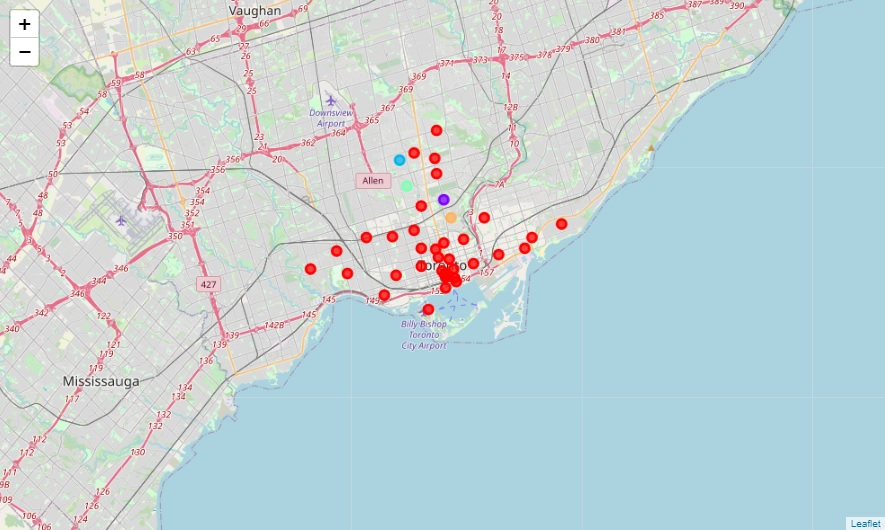

In [28]:
# Showing the output above.
Image(filename='toronto_venues_cluster_map.jpg') 

## Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

### Cluster 1

In [29]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, 
                   toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Park,Bakery,Pub,Café,Breakfast Spot,Restaurant,Theater,Cosmetics Shop,Shoe Store
1,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Music Venue,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,College Auditorium
2,Downtown Toronto,0,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Bubble Tea Shop,Hotel,Cosmetics Shop,Middle Eastern Restaurant,Italian Restaurant,Fast Food Restaurant
3,Downtown Toronto,0,Coffee Shop,Café,American Restaurant,Gastropub,Cocktail Bar,Department Store,Clothing Store,Park,Moroccan Restaurant,Lingerie Store
4,East Toronto,0,Asian Restaurant,Pizza Place,Trail,Pub,Health Food Store,Wine Bar,Discount Store,Department Store,Dessert Shop,Diner
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Bakery,Cheese Shop,Seafood Restaurant,Restaurant,Grocery Store,Japanese Restaurant
6,Downtown Toronto,0,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint,Salad Place,Bubble Tea Shop,Thai Restaurant,Ramen Restaurant,Portuguese Restaurant
7,Downtown Toronto,0,Grocery Store,Café,Park,Candy Store,Italian Restaurant,Restaurant,Baby Store,Athletics & Sports,Nightclub,Coffee Shop
8,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Hotel,Deli / Bodega,Gym,Thai Restaurant,Sushi Restaurant,Burrito Place,Pizza Place
9,West Toronto,0,Bakery,Pharmacy,Grocery Store,Supermarket,Bank,Bar,Middle Eastern Restaurant,Pool,Playground,Music Venue


### Cluster 2

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, 
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,1,Restaurant,Trail,Playground,Tennis Court,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Wine Bar


### Cluster 3

In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, 
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,2,Garden,Wine Bar,Deli / Bodega,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run


### Cluster 4

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, 
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,3,Park,Trail,Jewelry Store,Sushi Restaurant,Wine Bar,Deli / Bodega,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


### Cluster 5

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, 
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Downtown Toronto,4,Park,Trail,Playground,Dance Studio,Escape Room,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run


## Discriminating venues of clusters

- Most of Toronto Neightborhoods fall into Cluster 1, which are the areas with Coffe_Shop, Café, Park and others.
- Cluster 2 have Restaurant, Trail, Playgroung...
- Cluster 3 have Garden, Wine Bar, Deli/Bodega...
- Cluster 4 have Parl, Trail, Jewelry Store...
- Cluster 5 have Park, Tril, Playground...

With the above clusters, possibly, with less number of clusters, the greater the tendency for clusters 2, 3 and 4 to unify into a single cluster due to their venues similarities.